# Preprocessing

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, precision_score
import json
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import TransformerMixin
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

In [97]:
df_train = pd.read_csv("train+.csv")
df_train = df_train[sorted(df_train.columns)]
df_test = pd.read_csv("test+.csv")
df_test = df_test[sorted(df_test.columns)]

# df_train_filled = pd.read_csv("train_filled.csv")
# df_train_filled = df_train_filled[sorted(df_train_filled.columns)]
# df_test_filled = pd.read_csv("test_filled.csv")
# df_test_filled = df_test_filled[sorted(df_test_filled.columns)]

df_train.shape, df_test.shape

((4830, 76), (2071, 75))

# Utils

In [98]:
class FeaturesFilter(TransformerMixin):
    def __init__(self, needed_cols):
        self.needed_cols = needed_cols
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[:, self.needed_cols]

# Feature Engineering

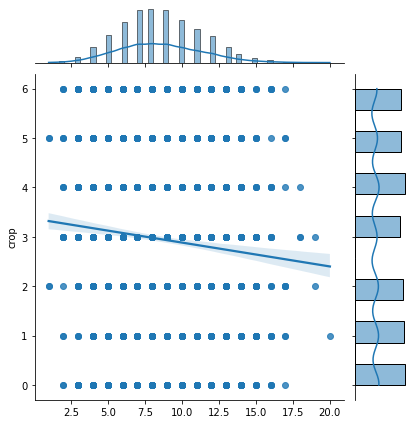

In [99]:
nd_cols = [col for col in df_train.columns if col.startswith('nd')]
np.argsort(df_train[nd_cols].values)
sns.jointplot(x=(df_train[nd_cols] == 0).sum(1), y=df_train['crop'], data=df_train, kind='reg')

In [100]:
def generate_features(df, mode, df_reference=None):
    df_reference = df if df_reference is None else df_reference
    
#     df['nd_mean'] = df[[col for col in df.columns if col.startswith('nd_mean_2021')]].mean(1)
#     df['nd_min'] = df[[col for col in df.columns if col.startswith('nd_mean_2021')]].min(1)
#     df['nd_max'] = df[[col for col in df.columns if col.startswith('nd_mean_2021')]].max(1)
#     df['nd_median'] = df[[col for col in df.columns if col.startswith('nd_mean_2021')]].median(1)
#     df['nd_var'] = df[[col for col in df.columns if col.startswith('nd_mean_2021')]].std(1)
    
    
    nd_cols = [col for col in df.columns if col.startswith('nd')]
    for col in nd_cols:
        df[f'{col}_bin'] = df[col] > 0.29
        
    k = 7
    if mode == 'train':
        kd = KDTree(df[['x_centroid', 'y_centroid']].values, metric='euclidean')
        distances, indices = kd.query(df[['x_centroid', 'y_centroid']], k=k + 1)
        distances, indices = distances[:, 1:], indices[:, 1:]
    else:
        kd = KDTree(df_reference[['x_centroid', 'y_centroid']].values, metric='euclidean')
        distances, indices = kd.query(df[['x_centroid', 'y_centroid']], k=k + 1)

    for i in range(k):
        df[f'distance_{i}'] = distances[:, i]
        df = df.join(pd.get_dummies(df_reference['crop'].values[indices[:, i]], prefix=f'closest_{i}_label=', prefix_sep=''))

#     for col in nd_cols:
#         df[f'{col}_rank'] = (df[col].values[:, None] > df[nd_cols].values).sum(1)
        
#     for i in range(10):
#         df[[f'nd_peak_{i}' for i in range(len(nd_cols))]] = np.argsort(df[nd_cols].values, axis=1)
    
#     for col in nd_cols:
#         df[f'{col}_bin'] = 0
#         df.loc[df[col] > 0.3, f'{col}_bin'] = 1
#         df.loc[df[col] > 0.5, f'{col}_bin'] = 2

#     df['is_poligon'] = df['.geo'].apply(lambda x: json.loads(x)['type'] == 'Polygon')
#     df['is_multipoligon'] = df['.geo'].apply(lambda x: json.loads(x)['type'] == 'MultiPolygon')
#     df['is_gc'] = df['.geo'].apply(lambda x: json.loads(x)['type'] == 'GeometryCollection')
#     df['bounds_count'] = df['.geo'].apply(lambda x: len(json.loads(x)['coordinates'][0]) if json.loads(x)['type'] == 'Polygon' else 0)
    
    return df

In [101]:
%%time
df_train = generate_features(df_train, 'train')
df_test = generate_features(df_test, 'test', df_train)
df_train.shape, df_test.shape

CPU times: user 73.6 ms, sys: 0 ns, total: 73.6 ms
Wall time: 73.3 ms


((4830, 210), (2071, 209))

In [102]:
max_corrs = []
for col in df_train.columns:
    if col not in ['id', '.geo', 'crop']:
        max_corrs.append((max(np.corrcoef(df_train[col], df_train['crop'] == i)[0][1] for i in range(7)), col))
max_corrs = sorted(max_corrs)
max_corrs

[(0.03148072333775203, 'nd_mean_2021-07-09_bin'),
 (0.034776853536755456, 'nd_mean_2021-06-20_bin'),
 (0.044589781529442644, 'nd_mean_2021-06-22_bin'),
 (0.045721301355917114, 'nd_mean_2021-06-25'),
 (0.04664101755866713, 'nd_mean_2021-07-07_bin'),
 (0.05298662556683655, 'nd_mean_2021-06-25_bin'),
 (0.06872198212174271, 'nd_mean_2021-05-16_bin'),
 (0.07410070707348924, 'nd_mean_2021-08-12_bin'),
 (0.08270526745432215, 'nd_mean_2021-06-18_bin'),
 (0.08438776779109501, 'nd_mean_2021-05-16'),
 (0.08604602258323403, 'nd_mean_2021-07-09'),
 (0.09632145957169705, 'nd_mean_2021-06-19_bin'),
 (0.09730060419359297, 'nd_mean_2021-07-07'),
 (0.10089297869317604, 'nd_mean_2021-07-13_bin'),
 (0.10401923069027018, 'nd_mean_2021-04-19_bin'),
 (0.1149691002840451, 'nd_mean_2021-07-08_bin'),
 (0.12084658030910116, 'nd_mean_2021-07-26_bin'),
 (0.12671732990227416, 'nd_mean_2021-07-13'),
 (0.13271257835319986, 'nd_mean_2021-04-28_bin'),
 (0.1329569168920107, 'nd_mean_2021-04-16_bin'),
 (0.133363480812701

In [103]:
bad_cols = [f[1] for f in max_corrs if f[0] < 0.1]
bad_cols = []
print(len(bad_cols))
X_train = df_train.drop(columns=['id', '.geo', 'crop'] + bad_cols)
X_test = df_test.drop(columns=['id', '.geo'] + bad_cols)
y_train = df_train['crop']
X_train

0


,area,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,...,closest_6_label=5,closest_6_label=6,distance_7,closest_7_label=0,closest_7_label=1,closest_7_label=2,closest_7_label=3,closest_7_label=4,closest_7_label=5,closest_7_label=6
0,20,0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,0.000000,0.077577,0.104442,...,0,0,0.078700,0,0,1,0,0,0,0
1,45,0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,0.173578,0.152467,...,0,0,0.319622,0,0,0,0,1,0,0
2,28,0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,0.112471,0.041751,0.037839,...,0,0,0.135481,0,0,1,0,0,0,0
3,19,0.293425,0.105976,0.318047,0.052500,0.153700,0.001917,0.045054,0.072589,0.011531,...,0,0,0.153200,0,0,0,0,0,1,0
4,33,0.027983,0.130885,0.117227,0.063492,0.040565,0.024416,0.163886,0.109385,0.000000,...,0,0,0.096134,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,74,0.066154,0.028770,0.000000,0.038282,0.000000,0.255329,0.095812,0.241602,0.148166,...,0,1,0.068248,0,0,0,0,0,0,1
4826,109,0.243867,0.035939,0.013403,0.030722,0.246513,0.033869,0.000000,0.022246,0.029646,...,0,0,0.057700,1,0,0,0,0,0,0
4827,58,0.090026,0.191255,0.019897,0.063581,0.000000,0.140111,0.143922,0.218746,0.323984,...,0,0,0.130890,0,0,1,0,0,0,0
4828,14,0.301663,0.291399,0.295089,0.221428,0.326494,0.007247,0.006888,0.000000,0.055074,...,1,0,0.165382,0,0,0,0,0,1,0


# Training

In [138]:
def cross_val_score(model, X, y, random_state=228, n_splits=5, fit_params={}):
    X, y = np.array(X), np.array(y)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    for train_index, test_index in kf.split(X, y):
        model.fit(X[train_index], y[train_index], **fit_params)
        scores.append(recall_score(y[test_index], model.predict(X[test_index]), average="macro", zero_division=0))
        print('SCORE:', scores[-1])
    return scores, model

In [139]:
knn = Pipeline([('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(7, weights='distance', p=2))])
scores, model = cross_val_score(knn, X_train[[c for c in X_train.columns if 'bin' not in c]], y_train,
                                random_state=228)
np.mean(scores), scores

SCORE: 0.8538333555999349
SCORE: 0.8607098143436585
SCORE: 0.8541245397421431
SCORE: 0.8547555845344432
SCORE: 0.8649918012584586


(0.8576830190957276,
 [0.8538333555999349,
  0.8607098143436585,
  0.8541245397421431,
  0.8547555845344432,
  0.8649918012584586])

In [125]:
logreg = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'dfdfd' not in c])),
                   ('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
scores, model = cross_val_score(logreg, X_train, y_train, n_splits=5)
np.mean(scores), scores

SCORE: 0.9608922970179563
SCORE: 0.9694948059371653
SCORE: 0.9677262283304501
SCORE: 0.9654960362040724
SCORE: 0.970689183100348


(0.9668597101179985,
 [0.9608922970179563,
  0.9694948059371653,
  0.9677262283304501,
  0.9654960362040724,
  0.970689183100348])

In [127]:
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=228))])
scores, model = cross_val_score(svc, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9650845034200712
SCORE: 0.9675802840819311
SCORE: 0.9716891171327088
SCORE: 0.9654855327747026
SCORE: 0.972017919252444


(0.9683714713323714,
 [0.9650845034200712,
  0.9675802840819311,
  0.9716891171327088,
  0.9654855327747026,
  0.972017919252444])

In [129]:
mlp = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'dfdfdf' not in c])),
                ('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
scores, model = cross_val_score(mlp, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9599415871223453
SCORE: 0.9541675613699879
SCORE: 0.9575232784269556
SCORE: 0.9624652583223741
SCORE: 0.9657645166657424


(0.9599724403814811,
 [0.9599415871223453,
  0.9541675613699879,
  0.9575232784269556,
  0.9624652583223741,
  0.9657645166657424])

In [18]:
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
scores, model = cross_val_score(rf, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9640653623534262
SCORE: 0.9766366764253668
SCORE: 0.9676409766664242
SCORE: 0.9716300646636651
SCORE: 0.9648738067988247


(0.9689693773815413,
 [0.9640653623534262,
  0.9766366764253668,
  0.9676409766664242,
  0.9716300646636651,
  0.9648738067988247])

In [132]:
%%time
lgbm = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
scores, model = cross_val_score(lgbm, X_train, y_train)
np.mean(scores), scores

SCORE: 0.969170493489455
SCORE: 0.9746537878405006
SCORE: 0.9758172931264973
SCORE: 0.9744500591680946
SCORE: 0.9738333970077713
CPU times: user 2min 7s, sys: 265 ms, total: 2min 7s
Wall time: 16.7 s


(0.9735850061264637,
 [0.969170493489455,
  0.9746537878405006,
  0.9758172931264973,
  0.9744500591680946,
  0.9738333970077713])

In [20]:
%%time
lgbm = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=228228)
scores, model = cross_val_score(lgbm, X_train, y_train)
np.mean(scores), scores

SCORE: 0.96727525868652
SCORE: 0.9736685661656238
SCORE: 0.9748745990059318
SCORE: 0.972479615818341
SCORE: 0.9760021521376965
CPU times: user 1min 58s, sys: 259 ms, total: 1min 59s
Wall time: 13.6 s


(0.9728600383628226,
 [0.96727525868652,
  0.9736685661656238,
  0.9748745990059318,
  0.972479615818341,
  0.9760021521376965])

In [114]:
%%time
lgbm = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=18))
])
scores, model = cross_val_score(lgbm, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9680074874521944
SCORE: 0.981823857925401
SCORE: 0.9747720231903666
SCORE: 0.9725467129003633
SCORE: 0.9709097473748828
CPU times: user 1min 12s, sys: 136 ms, total: 1min 12s
Wall time: 9.42 s


(0.9736119657686416,
 [0.9680074874521944,
  0.981823857925401,
  0.9747720231903666,
  0.9725467129003633,
  0.9709097473748828])

In [135]:
%%time
lgbm = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=18))
])
scores, model = cross_val_score(lgbm, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9639640249371217
SCORE: 0.9818663854797121
SCORE: 0.971816358165736
SCORE: 0.9726061821422457
SCORE: 0.9687409922449577
CPU times: user 1min 18s, sys: 213 ms, total: 1min 18s
Wall time: 10.3 s


(0.9717987885939546,
 [0.9639640249371217,
  0.9818663854797121,
  0.971816358165736,
  0.9726061821422457,
  0.9687409922449577])

In [133]:
%%time
lgbm = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'bin' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='goss', max_depth=2, learning_rate=0.27, n_estimators=100, random_state=7))
])
scores, model = cross_val_score(lgbm, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9525727079747652
SCORE: 0.9786555551292141
SCORE: 0.9642849995609988
SCORE: 0.9706433666326323
SCORE: 0.9677302201352053
CPU times: user 9.65 s, sys: 15.2 ms, total: 9.66 s
Wall time: 1.33 s


(0.966777369886563,
 [0.9525727079747652,
  0.9786555551292141,
  0.9642849995609988,
  0.9706433666326323,
  0.9677302201352053])

In [24]:
%%time
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)
scores, model = cross_val_score(ctb, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9620178796700953
SCORE: 0.9746905955997425
SCORE: 0.9726742868718442
SCORE: 0.9645245938533197
SCORE: 0.9678171041030244
CPU times: user 9min 12s, sys: 4.13 s, total: 9min 17s
Wall time: 1min 18s


(0.9683448920196053,
 [0.9620178796700953,
  0.9746905955997425,
  0.9726742868718442,
  0.9645245938533197,
  0.9678171041030244])

In [25]:
%%time
ctb = CatBoostClassifier(n_estimators=300, depth=3, random_state=18, verbose=False)
scores, model = cross_val_score(ctb, X_train, y_train)
np.mean(scores), scores

SCORE: 0.9639928688570597
SCORE: 0.9735701171167931
SCORE: 0.9728449786594499
SCORE: 0.9725010229826052
SCORE: 0.9709429256498986
CPU times: user 1min 8s, sys: 2.05 s, total: 1min 10s
Wall time: 10.7 s


(0.9707703826531613,
 [0.9639928688570597,
  0.9735701171167931,
  0.9728449786594499,
  0.9725010229826052,
  0.9709429256498986])

# Stacking

In [492]:
%%time
# k = 8!!!!!!!!!!!!!
SEED = 228
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=SEED))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=SEED))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=SEED))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=SEED)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=SEED + 1))
])
lgbm_3 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=SEED + 2)
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
#     ('lgbm_3', lgbm_3),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators,
                         final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=SEED),
                         n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9721862067753396


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9748247303856977


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9830187126272166


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9817299860642262
SCORE: 0.9729496839549369
CPU times: user 1min 32s, sys: 15.4 s, total: 1min 47s
Wall time: 9min 38s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9769418639614834,
 [0.9721862067753396,
  0.9748247303856977,
  0.9830187126272166,
  0.9817299860642262,
  0.9729496839549369])

In [303]:
%%time
# THIS IS BEST ON PUBLIC
# k = 7
knn = Pipeline([('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(7, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
svc = Pipeline([('min_max', StandardScaler()),
                ('svc', SVC(C=4.00000000001, kernel='rbf', random_state=228))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
rf = RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228)
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=18))
])
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(max_depth=2, random_state=228))
scores, model = cross_val_score(clf, X_train, y_train)
np.mean(scores), scores

Learning rate set to 0.084774
0:	learn: 1.8004636	total: 2.57ms	remaining: 2.57s
1:	learn: 1.6587048	total: 4.7ms	remaining: 2.35s
2:	learn: 1.5326970	total: 6.81ms	remaining: 2.26s
3:	learn: 1.4253540	total: 8.86ms	remaining: 2.21s
4:	learn: 1.3378497	total: 11.1ms	remaining: 2.21s
5:	learn: 1.2570410	total: 13.2ms	remaining: 2.18s
6:	learn: 1.1881264	total: 15.1ms	remaining: 2.15s
7:	learn: 1.1231943	total: 17.2ms	remaining: 2.13s
8:	learn: 1.0656333	total: 19.3ms	remaining: 2.13s
9:	learn: 1.0064358	total: 21.5ms	remaining: 2.13s
10:	learn: 0.9550756	total: 23.7ms	remaining: 2.13s
11:	learn: 0.9104482	total: 25.9ms	remaining: 2.13s
12:	learn: 0.8655818	total: 28.2ms	remaining: 2.14s
13:	learn: 0.8240511	total: 30.3ms	remaining: 2.13s
14:	learn: 0.7866037	total: 32.7ms	remaining: 2.14s
15:	learn: 0.7503171	total: 34.9ms	remaining: 2.15s
16:	learn: 0.7169433	total: 37.1ms	remaining: 2.15s
17:	learn: 0.6855691	total: 39.3ms	remaining: 2.14s
18:	learn: 0.6580922	total: 41.5ms	remaining:

162:	learn: 0.0697450	total: 389ms	remaining: 2s
163:	learn: 0.0696389	total: 392ms	remaining: 2s
164:	learn: 0.0694916	total: 395ms	remaining: 2s
165:	learn: 0.0692930	total: 397ms	remaining: 2s
166:	learn: 0.0690576	total: 400ms	remaining: 2s
167:	learn: 0.0689665	total: 403ms	remaining: 1.99s
168:	learn: 0.0687705	total: 410ms	remaining: 2.02s
169:	learn: 0.0686868	total: 415ms	remaining: 2.02s
170:	learn: 0.0686324	total: 417ms	remaining: 2.02s
171:	learn: 0.0684843	total: 420ms	remaining: 2.02s
172:	learn: 0.0680656	total: 423ms	remaining: 2.02s
173:	learn: 0.0679870	total: 427ms	remaining: 2.03s
174:	learn: 0.0676383	total: 431ms	remaining: 2.03s
175:	learn: 0.0674396	total: 433ms	remaining: 2.03s
176:	learn: 0.0672918	total: 436ms	remaining: 2.03s
177:	learn: 0.0672313	total: 441ms	remaining: 2.04s
178:	learn: 0.0669703	total: 444ms	remaining: 2.04s
179:	learn: 0.0668270	total: 446ms	remaining: 2.03s
180:	learn: 0.0667130	total: 449ms	remaining: 2.03s
181:	learn: 0.0664742	total

391:	learn: 0.0455680	total: 975ms	remaining: 1.51s
392:	learn: 0.0453957	total: 978ms	remaining: 1.51s
393:	learn: 0.0452963	total: 981ms	remaining: 1.51s
394:	learn: 0.0451924	total: 984ms	remaining: 1.51s
395:	learn: 0.0451006	total: 987ms	remaining: 1.5s
396:	learn: 0.0450342	total: 990ms	remaining: 1.5s
397:	learn: 0.0449618	total: 992ms	remaining: 1.5s
398:	learn: 0.0447874	total: 994ms	remaining: 1.5s
399:	learn: 0.0447636	total: 997ms	remaining: 1.5s
400:	learn: 0.0447348	total: 1000ms	remaining: 1.49s
401:	learn: 0.0446875	total: 1s	remaining: 1.49s
402:	learn: 0.0445888	total: 1s	remaining: 1.49s
403:	learn: 0.0444677	total: 1.01s	remaining: 1.49s
404:	learn: 0.0444386	total: 1.01s	remaining: 1.48s
405:	learn: 0.0443612	total: 1.01s	remaining: 1.48s
406:	learn: 0.0442876	total: 1.01s	remaining: 1.48s
407:	learn: 0.0442209	total: 1.02s	remaining: 1.48s
408:	learn: 0.0441548	total: 1.02s	remaining: 1.47s
409:	learn: 0.0440864	total: 1.02s	remaining: 1.47s
410:	learn: 0.0440640	

620:	learn: 0.0345229	total: 1.56s	remaining: 956ms
621:	learn: 0.0345028	total: 1.57s	remaining: 953ms
622:	learn: 0.0344895	total: 1.57s	remaining: 950ms
623:	learn: 0.0344768	total: 1.57s	remaining: 948ms
624:	learn: 0.0344258	total: 1.57s	remaining: 945ms
625:	learn: 0.0343805	total: 1.58s	remaining: 943ms
626:	learn: 0.0343535	total: 1.58s	remaining: 941ms
627:	learn: 0.0343091	total: 1.58s	remaining: 939ms
628:	learn: 0.0342876	total: 1.59s	remaining: 937ms
629:	learn: 0.0342453	total: 1.59s	remaining: 934ms
630:	learn: 0.0341921	total: 1.59s	remaining: 932ms
631:	learn: 0.0341255	total: 1.6s	remaining: 931ms
632:	learn: 0.0341012	total: 1.6s	remaining: 928ms
633:	learn: 0.0340572	total: 1.6s	remaining: 926ms
634:	learn: 0.0340459	total: 1.6s	remaining: 923ms
635:	learn: 0.0340346	total: 1.61s	remaining: 920ms
636:	learn: 0.0339468	total: 1.61s	remaining: 918ms
637:	learn: 0.0339096	total: 1.61s	remaining: 916ms
638:	learn: 0.0338767	total: 1.62s	remaining: 914ms
639:	learn: 0.03

843:	learn: 0.0275320	total: 2.15s	remaining: 398ms
844:	learn: 0.0275055	total: 2.15s	remaining: 395ms
845:	learn: 0.0274880	total: 2.16s	remaining: 393ms
846:	learn: 0.0274497	total: 2.16s	remaining: 390ms
847:	learn: 0.0274184	total: 2.16s	remaining: 388ms
848:	learn: 0.0274019	total: 2.17s	remaining: 385ms
849:	learn: 0.0273643	total: 2.17s	remaining: 383ms
850:	learn: 0.0273307	total: 2.17s	remaining: 380ms
851:	learn: 0.0273179	total: 2.17s	remaining: 378ms
852:	learn: 0.0272844	total: 2.18s	remaining: 375ms
853:	learn: 0.0272317	total: 2.18s	remaining: 372ms
854:	learn: 0.0271831	total: 2.18s	remaining: 370ms
855:	learn: 0.0271443	total: 2.18s	remaining: 367ms
856:	learn: 0.0271319	total: 2.19s	remaining: 365ms
857:	learn: 0.0271066	total: 2.19s	remaining: 363ms
858:	learn: 0.0270775	total: 2.19s	remaining: 360ms
859:	learn: 0.0270415	total: 2.19s	remaining: 357ms
860:	learn: 0.0270026	total: 2.2s	remaining: 355ms
861:	learn: 0.0269882	total: 2.2s	remaining: 352ms
862:	learn: 0.

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9721398421484589
Learning rate set to 0.084774
0:	learn: 1.7952338	total: 2.54ms	remaining: 2.54s
1:	learn: 1.6550797	total: 4.82ms	remaining: 2.4s
2:	learn: 1.5406819	total: 7.04ms	remaining: 2.34s
3:	learn: 1.4182473	total: 9.22ms	remaining: 2.3s
4:	learn: 1.3351302	total: 11.4ms	remaining: 2.26s
5:	learn: 1.2516525	total: 13.6ms	remaining: 2.25s
6:	learn: 1.1774451	total: 15.8ms	remaining: 2.24s
7:	learn: 1.1171645	total: 18ms	remaining: 2.23s
8:	learn: 1.0572239	total: 20.2ms	remaining: 2.23s
9:	learn: 1.0053227	total: 22.4ms	remaining: 2.22s
10:	learn: 0.9502101	total: 24.6ms	remaining: 2.21s
11:	learn: 0.9037570	total: 26.8ms	remaining: 2.21s
12:	learn: 0.8598018	total: 29ms	remaining: 2.2s
13:	learn: 0.8180238	total: 31.4ms	remaining: 2.21s
14:	learn: 0.7811306	total: 33.6ms	remaining: 2.21s
15:	learn: 0.7459022	total: 35.8ms	remaining: 2.2s
16:	learn: 0.7105749	total: 38.1ms	remaining: 2.2s
17:	learn: 0.6801028	total: 40.4ms	remaining: 2.2s
18:	learn: 0.6536716	total: 

161:	learn: 0.0687499	total: 387ms	remaining: 2s
162:	learn: 0.0685022	total: 390ms	remaining: 2s
163:	learn: 0.0682339	total: 393ms	remaining: 2s
164:	learn: 0.0679620	total: 395ms	remaining: 2s
165:	learn: 0.0675103	total: 398ms	remaining: 2s
166:	learn: 0.0674962	total: 401ms	remaining: 2s
167:	learn: 0.0672346	total: 403ms	remaining: 2s
168:	learn: 0.0671696	total: 406ms	remaining: 2s
169:	learn: 0.0670198	total: 408ms	remaining: 1.99s
170:	learn: 0.0668019	total: 411ms	remaining: 1.99s
171:	learn: 0.0666926	total: 414ms	remaining: 1.99s
172:	learn: 0.0665018	total: 417ms	remaining: 1.99s
173:	learn: 0.0661000	total: 419ms	remaining: 1.99s
174:	learn: 0.0658108	total: 421ms	remaining: 1.99s
175:	learn: 0.0655123	total: 424ms	remaining: 1.98s
176:	learn: 0.0653136	total: 426ms	remaining: 1.98s
177:	learn: 0.0652826	total: 429ms	remaining: 1.98s
178:	learn: 0.0651278	total: 431ms	remaining: 1.98s
179:	learn: 0.0649072	total: 433ms	remaining: 1.97s
180:	learn: 0.0647211	total: 436ms	r

396:	learn: 0.0429731	total: 975ms	remaining: 1.48s
397:	learn: 0.0429295	total: 978ms	remaining: 1.48s
398:	learn: 0.0429041	total: 981ms	remaining: 1.48s
399:	learn: 0.0428037	total: 985ms	remaining: 1.48s
400:	learn: 0.0427489	total: 987ms	remaining: 1.47s
401:	learn: 0.0426869	total: 990ms	remaining: 1.47s
402:	learn: 0.0425657	total: 993ms	remaining: 1.47s
403:	learn: 0.0425277	total: 996ms	remaining: 1.47s
404:	learn: 0.0424209	total: 998ms	remaining: 1.47s
405:	learn: 0.0424038	total: 1s	remaining: 1.46s
406:	learn: 0.0423972	total: 1s	remaining: 1.46s
407:	learn: 0.0422917	total: 1s	remaining: 1.46s
408:	learn: 0.0421510	total: 1.01s	remaining: 1.46s
409:	learn: 0.0420847	total: 1.01s	remaining: 1.45s
410:	learn: 0.0420581	total: 1.01s	remaining: 1.45s
411:	learn: 0.0420316	total: 1.01s	remaining: 1.45s
412:	learn: 0.0419825	total: 1.02s	remaining: 1.45s
413:	learn: 0.0419302	total: 1.02s	remaining: 1.45s
414:	learn: 0.0419031	total: 1.02s	remaining: 1.44s
415:	learn: 0.0418838

628:	learn: 0.0326650	total: 1.56s	remaining: 920ms
629:	learn: 0.0326117	total: 1.56s	remaining: 918ms
630:	learn: 0.0325884	total: 1.56s	remaining: 916ms
631:	learn: 0.0324980	total: 1.57s	remaining: 913ms
632:	learn: 0.0324266	total: 1.57s	remaining: 911ms
633:	learn: 0.0323839	total: 1.57s	remaining: 909ms
634:	learn: 0.0323722	total: 1.58s	remaining: 907ms
635:	learn: 0.0323167	total: 1.58s	remaining: 904ms
636:	learn: 0.0323100	total: 1.58s	remaining: 902ms
637:	learn: 0.0322799	total: 1.58s	remaining: 899ms
638:	learn: 0.0322494	total: 1.59s	remaining: 897ms
639:	learn: 0.0322020	total: 1.59s	remaining: 894ms
640:	learn: 0.0321700	total: 1.59s	remaining: 892ms
641:	learn: 0.0321357	total: 1.59s	remaining: 889ms
642:	learn: 0.0321225	total: 1.6s	remaining: 886ms
643:	learn: 0.0321042	total: 1.6s	remaining: 884ms
644:	learn: 0.0320978	total: 1.6s	remaining: 881ms
645:	learn: 0.0320339	total: 1.6s	remaining: 879ms
646:	learn: 0.0319612	total: 1.61s	remaining: 876ms
647:	learn: 0.03

858:	learn: 0.0255092	total: 2.14s	remaining: 352ms
859:	learn: 0.0253764	total: 2.14s	remaining: 349ms
860:	learn: 0.0253590	total: 2.15s	remaining: 347ms
861:	learn: 0.0253473	total: 2.15s	remaining: 344ms
862:	learn: 0.0253401	total: 2.15s	remaining: 342ms
863:	learn: 0.0253303	total: 2.15s	remaining: 339ms
864:	learn: 0.0253208	total: 2.16s	remaining: 337ms
865:	learn: 0.0253154	total: 2.16s	remaining: 334ms
866:	learn: 0.0253052	total: 2.16s	remaining: 332ms
867:	learn: 0.0252731	total: 2.17s	remaining: 329ms
868:	learn: 0.0252580	total: 2.17s	remaining: 327ms
869:	learn: 0.0252326	total: 2.17s	remaining: 324ms
870:	learn: 0.0252081	total: 2.17s	remaining: 322ms
871:	learn: 0.0251772	total: 2.18s	remaining: 319ms
872:	learn: 0.0251335	total: 2.18s	remaining: 317ms
873:	learn: 0.0251067	total: 2.18s	remaining: 314ms
874:	learn: 0.0250671	total: 2.18s	remaining: 312ms
875:	learn: 0.0250555	total: 2.19s	remaining: 309ms
876:	learn: 0.0250163	total: 2.19s	remaining: 307ms
877:	learn: 

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9768552219967054
Learning rate set to 0.084774
0:	learn: 1.7952709	total: 2.51ms	remaining: 2.51s
1:	learn: 1.6556247	total: 5.86ms	remaining: 2.92s
2:	learn: 1.5227325	total: 8.04ms	remaining: 2.67s
3:	learn: 1.4175403	total: 10.1ms	remaining: 2.5s
4:	learn: 1.3316342	total: 12.3ms	remaining: 2.44s
5:	learn: 1.2586311	total: 14.3ms	remaining: 2.37s
6:	learn: 1.1840057	total: 16.4ms	remaining: 2.32s
7:	learn: 1.1241414	total: 20.5ms	remaining: 2.54s
8:	learn: 1.0591882	total: 22.6ms	remaining: 2.49s
9:	learn: 1.0066013	total: 24.7ms	remaining: 2.45s
10:	learn: 0.9498165	total: 26.8ms	remaining: 2.41s
11:	learn: 0.9033298	total: 28.9ms	remaining: 2.38s
12:	learn: 0.8604216	total: 30.9ms	remaining: 2.35s
13:	learn: 0.8197736	total: 33.1ms	remaining: 2.33s
14:	learn: 0.7838322	total: 35.5ms	remaining: 2.33s
15:	learn: 0.7481568	total: 37.8ms	remaining: 2.33s
16:	learn: 0.7156720	total: 40ms	remaining: 2.31s
17:	learn: 0.6846835	total: 42.1ms	remaining: 2.29s
18:	learn: 0.6560387	

160:	learn: 0.0741376	total: 390ms	remaining: 2.03s
161:	learn: 0.0740203	total: 394ms	remaining: 2.04s
162:	learn: 0.0737372	total: 396ms	remaining: 2.03s
163:	learn: 0.0734767	total: 399ms	remaining: 2.03s
164:	learn: 0.0734079	total: 401ms	remaining: 2.03s
165:	learn: 0.0731595	total: 404ms	remaining: 2.03s
166:	learn: 0.0728024	total: 406ms	remaining: 2.03s
167:	learn: 0.0726306	total: 409ms	remaining: 2.02s
168:	learn: 0.0723733	total: 411ms	remaining: 2.02s
169:	learn: 0.0721586	total: 414ms	remaining: 2.02s
170:	learn: 0.0719887	total: 416ms	remaining: 2.02s
171:	learn: 0.0715430	total: 418ms	remaining: 2.01s
172:	learn: 0.0713291	total: 421ms	remaining: 2.01s
173:	learn: 0.0711872	total: 423ms	remaining: 2.01s
174:	learn: 0.0710975	total: 426ms	remaining: 2.01s
175:	learn: 0.0708987	total: 428ms	remaining: 2s
176:	learn: 0.0705641	total: 431ms	remaining: 2s
177:	learn: 0.0703229	total: 434ms	remaining: 2s
178:	learn: 0.0701914	total: 436ms	remaining: 2s
179:	learn: 0.0699821	to

385:	learn: 0.0464529	total: 977ms	remaining: 1.55s
386:	learn: 0.0464342	total: 980ms	remaining: 1.55s
387:	learn: 0.0463769	total: 982ms	remaining: 1.55s
388:	learn: 0.0463567	total: 985ms	remaining: 1.55s
389:	learn: 0.0462565	total: 987ms	remaining: 1.54s
390:	learn: 0.0461367	total: 990ms	remaining: 1.54s
391:	learn: 0.0460711	total: 992ms	remaining: 1.54s
392:	learn: 0.0460554	total: 995ms	remaining: 1.54s
393:	learn: 0.0459818	total: 997ms	remaining: 1.53s
394:	learn: 0.0459478	total: 1000ms	remaining: 1.53s
395:	learn: 0.0458724	total: 1s	remaining: 1.53s
396:	learn: 0.0458108	total: 1s	remaining: 1.52s
397:	learn: 0.0457808	total: 1.01s	remaining: 1.52s
398:	learn: 0.0456453	total: 1.01s	remaining: 1.52s
399:	learn: 0.0456048	total: 1.01s	remaining: 1.52s
400:	learn: 0.0454464	total: 1.01s	remaining: 1.51s
401:	learn: 0.0453437	total: 1.02s	remaining: 1.51s
402:	learn: 0.0453150	total: 1.02s	remaining: 1.51s
403:	learn: 0.0452339	total: 1.02s	remaining: 1.51s
404:	learn: 0.045

606:	learn: 0.0351911	total: 1.56s	remaining: 1.01s
607:	learn: 0.0351681	total: 1.56s	remaining: 1.01s
608:	learn: 0.0351405	total: 1.57s	remaining: 1.01s
609:	learn: 0.0351218	total: 1.57s	remaining: 1s
610:	learn: 0.0350921	total: 1.57s	remaining: 1s
611:	learn: 0.0350018	total: 1.57s	remaining: 998ms
612:	learn: 0.0349629	total: 1.58s	remaining: 996ms
613:	learn: 0.0349401	total: 1.58s	remaining: 993ms
614:	learn: 0.0348768	total: 1.58s	remaining: 991ms
615:	learn: 0.0348580	total: 1.58s	remaining: 988ms
616:	learn: 0.0348158	total: 1.59s	remaining: 985ms
617:	learn: 0.0347917	total: 1.59s	remaining: 983ms
618:	learn: 0.0347484	total: 1.59s	remaining: 981ms
619:	learn: 0.0346926	total: 1.6s	remaining: 978ms
620:	learn: 0.0346698	total: 1.6s	remaining: 976ms
621:	learn: 0.0345746	total: 1.6s	remaining: 973ms
622:	learn: 0.0345227	total: 1.6s	remaining: 971ms
623:	learn: 0.0345018	total: 1.61s	remaining: 968ms
624:	learn: 0.0344770	total: 1.61s	remaining: 966ms
625:	learn: 0.0344202	

828:	learn: 0.0276444	total: 2.15s	remaining: 443ms
829:	learn: 0.0276118	total: 2.15s	remaining: 441ms
830:	learn: 0.0275726	total: 2.15s	remaining: 438ms
831:	learn: 0.0275009	total: 2.16s	remaining: 436ms
832:	learn: 0.0274949	total: 2.16s	remaining: 433ms
833:	learn: 0.0274749	total: 2.16s	remaining: 430ms
834:	learn: 0.0274397	total: 2.16s	remaining: 428ms
835:	learn: 0.0274041	total: 2.17s	remaining: 425ms
836:	learn: 0.0273868	total: 2.17s	remaining: 422ms
837:	learn: 0.0273366	total: 2.17s	remaining: 420ms
838:	learn: 0.0273046	total: 2.17s	remaining: 417ms
839:	learn: 0.0272732	total: 2.18s	remaining: 415ms
840:	learn: 0.0272510	total: 2.18s	remaining: 412ms
841:	learn: 0.0272422	total: 2.18s	remaining: 410ms
842:	learn: 0.0272183	total: 2.19s	remaining: 407ms
843:	learn: 0.0271654	total: 2.19s	remaining: 405ms
844:	learn: 0.0271476	total: 2.19s	remaining: 402ms
845:	learn: 0.0271094	total: 2.19s	remaining: 399ms
846:	learn: 0.0270645	total: 2.2s	remaining: 397ms
847:	learn: 0

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9840107761192802
Learning rate set to 0.084774
0:	learn: 1.7959156	total: 2.38ms	remaining: 2.38s
1:	learn: 1.6603088	total: 4.5ms	remaining: 2.24s
2:	learn: 1.5510529	total: 6.71ms	remaining: 2.23s
3:	learn: 1.4243889	total: 9.17ms	remaining: 2.28s
4:	learn: 1.3398998	total: 11.8ms	remaining: 2.35s
5:	learn: 1.2614573	total: 14.6ms	remaining: 2.42s
6:	learn: 1.1862128	total: 16.9ms	remaining: 2.39s
7:	learn: 1.1264092	total: 19.2ms	remaining: 2.38s
8:	learn: 1.0651645	total: 21.4ms	remaining: 2.36s
9:	learn: 1.0134331	total: 23.6ms	remaining: 2.34s
10:	learn: 0.9587298	total: 25.9ms	remaining: 2.33s
11:	learn: 0.9113105	total: 28.2ms	remaining: 2.32s
12:	learn: 0.8658733	total: 30.6ms	remaining: 2.32s
13:	learn: 0.8247430	total: 32.9ms	remaining: 2.31s
14:	learn: 0.7868941	total: 35.3ms	remaining: 2.31s
15:	learn: 0.7509175	total: 37.5ms	remaining: 2.31s
16:	learn: 0.7187398	total: 39.8ms	remaining: 2.3s
17:	learn: 0.6880370	total: 42.1ms	remaining: 2.29s
18:	learn: 0.6597614

234:	learn: 0.0571744	total: 582ms	remaining: 1.9s
235:	learn: 0.0570533	total: 585ms	remaining: 1.89s
236:	learn: 0.0569129	total: 588ms	remaining: 1.89s
237:	learn: 0.0568037	total: 590ms	remaining: 1.89s
238:	learn: 0.0567302	total: 592ms	remaining: 1.89s
239:	learn: 0.0565714	total: 595ms	remaining: 1.88s
240:	learn: 0.0564759	total: 597ms	remaining: 1.88s
241:	learn: 0.0563903	total: 600ms	remaining: 1.88s
242:	learn: 0.0563560	total: 602ms	remaining: 1.88s
243:	learn: 0.0562725	total: 605ms	remaining: 1.87s
244:	learn: 0.0561471	total: 607ms	remaining: 1.87s
245:	learn: 0.0560142	total: 609ms	remaining: 1.87s
246:	learn: 0.0559423	total: 612ms	remaining: 1.86s
247:	learn: 0.0558757	total: 614ms	remaining: 1.86s
248:	learn: 0.0557643	total: 616ms	remaining: 1.86s
249:	learn: 0.0556769	total: 619ms	remaining: 1.86s
250:	learn: 0.0555491	total: 621ms	remaining: 1.85s
251:	learn: 0.0555064	total: 624ms	remaining: 1.85s
252:	learn: 0.0554154	total: 626ms	remaining: 1.85s
253:	learn: 0

466:	learn: 0.0392271	total: 1.17s	remaining: 1.33s
467:	learn: 0.0391957	total: 1.17s	remaining: 1.33s
468:	learn: 0.0391703	total: 1.17s	remaining: 1.33s
469:	learn: 0.0391388	total: 1.17s	remaining: 1.32s
470:	learn: 0.0391117	total: 1.18s	remaining: 1.32s
471:	learn: 0.0390864	total: 1.18s	remaining: 1.32s
472:	learn: 0.0390439	total: 1.18s	remaining: 1.32s
473:	learn: 0.0389634	total: 1.18s	remaining: 1.31s
474:	learn: 0.0389131	total: 1.19s	remaining: 1.31s
475:	learn: 0.0388921	total: 1.19s	remaining: 1.31s
476:	learn: 0.0388705	total: 1.19s	remaining: 1.31s
477:	learn: 0.0388199	total: 1.19s	remaining: 1.3s
478:	learn: 0.0387529	total: 1.2s	remaining: 1.3s
479:	learn: 0.0387047	total: 1.2s	remaining: 1.3s
480:	learn: 0.0386673	total: 1.2s	remaining: 1.3s
481:	learn: 0.0386221	total: 1.2s	remaining: 1.29s
482:	learn: 0.0386061	total: 1.21s	remaining: 1.29s
483:	learn: 0.0385052	total: 1.21s	remaining: 1.29s
484:	learn: 0.0384501	total: 1.21s	remaining: 1.29s
485:	learn: 0.038415

696:	learn: 0.0291657	total: 1.75s	remaining: 761ms
697:	learn: 0.0291382	total: 1.75s	remaining: 758ms
698:	learn: 0.0291043	total: 1.75s	remaining: 756ms
699:	learn: 0.0290934	total: 1.76s	remaining: 753ms
700:	learn: 0.0290652	total: 1.76s	remaining: 751ms
701:	learn: 0.0290426	total: 1.76s	remaining: 748ms
702:	learn: 0.0290288	total: 1.76s	remaining: 745ms
703:	learn: 0.0289908	total: 1.77s	remaining: 743ms
704:	learn: 0.0289472	total: 1.77s	remaining: 740ms
705:	learn: 0.0289333	total: 1.77s	remaining: 738ms
706:	learn: 0.0288783	total: 1.77s	remaining: 735ms
707:	learn: 0.0288667	total: 1.78s	remaining: 733ms
708:	learn: 0.0288408	total: 1.78s	remaining: 730ms
709:	learn: 0.0288103	total: 1.78s	remaining: 728ms
710:	learn: 0.0288047	total: 1.78s	remaining: 725ms
711:	learn: 0.0287730	total: 1.79s	remaining: 723ms
712:	learn: 0.0287591	total: 1.79s	remaining: 720ms
713:	learn: 0.0286685	total: 1.79s	remaining: 718ms
714:	learn: 0.0286383	total: 1.8s	remaining: 716ms
715:	learn: 0

930:	learn: 0.0228145	total: 2.33s	remaining: 173ms
931:	learn: 0.0228032	total: 2.34s	remaining: 171ms
932:	learn: 0.0227809	total: 2.34s	remaining: 168ms
933:	learn: 0.0227430	total: 2.34s	remaining: 166ms
934:	learn: 0.0227192	total: 2.35s	remaining: 163ms
935:	learn: 0.0227015	total: 2.35s	remaining: 161ms
936:	learn: 0.0226689	total: 2.35s	remaining: 158ms
937:	learn: 0.0226380	total: 2.35s	remaining: 156ms
938:	learn: 0.0226251	total: 2.35s	remaining: 153ms
939:	learn: 0.0226192	total: 2.36s	remaining: 151ms
940:	learn: 0.0225895	total: 2.36s	remaining: 148ms
941:	learn: 0.0225711	total: 2.36s	remaining: 145ms
942:	learn: 0.0225373	total: 2.37s	remaining: 143ms
943:	learn: 0.0225302	total: 2.37s	remaining: 140ms
944:	learn: 0.0224767	total: 2.37s	remaining: 138ms
945:	learn: 0.0224411	total: 2.37s	remaining: 135ms
946:	learn: 0.0224109	total: 2.38s	remaining: 133ms
947:	learn: 0.0223569	total: 2.38s	remaining: 130ms
948:	learn: 0.0223415	total: 2.38s	remaining: 128ms
949:	learn: 

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9775526216302629
Learning rate set to 0.084774
0:	learn: 1.7945642	total: 2.43ms	remaining: 2.42s
1:	learn: 1.6557400	total: 4.65ms	remaining: 2.32s
2:	learn: 1.5341209	total: 6.91ms	remaining: 2.29s
3:	learn: 1.4327567	total: 9.18ms	remaining: 2.29s
4:	learn: 1.3468700	total: 11.5ms	remaining: 2.29s
5:	learn: 1.2705873	total: 13.8ms	remaining: 2.29s
6:	learn: 1.1904355	total: 16ms	remaining: 2.26s
7:	learn: 1.1248352	total: 18.2ms	remaining: 2.26s
8:	learn: 1.0676005	total: 20.4ms	remaining: 2.25s
9:	learn: 1.0115190	total: 22.7ms	remaining: 2.24s
10:	learn: 0.9584402	total: 25.1ms	remaining: 2.25s
11:	learn: 0.9127221	total: 27.6ms	remaining: 2.27s
12:	learn: 0.8674390	total: 29.9ms	remaining: 2.27s
13:	learn: 0.8286384	total: 32.1ms	remaining: 2.26s
14:	learn: 0.7899778	total: 37.1ms	remaining: 2.43s
15:	learn: 0.7530814	total: 39.7ms	remaining: 2.44s
16:	learn: 0.7203601	total: 42.3ms	remaining: 2.45s
17:	learn: 0.6895289	total: 44.9ms	remaining: 2.45s
18:	learn: 0.6598752

223:	learn: 0.0542369	total: 585ms	remaining: 2.02s
224:	learn: 0.0541447	total: 587ms	remaining: 2.02s
225:	learn: 0.0540227	total: 590ms	remaining: 2.02s
226:	learn: 0.0539149	total: 592ms	remaining: 2.02s
227:	learn: 0.0535456	total: 595ms	remaining: 2.01s
228:	learn: 0.0535264	total: 597ms	remaining: 2.01s
229:	learn: 0.0532450	total: 600ms	remaining: 2.01s
230:	learn: 0.0531043	total: 605ms	remaining: 2.01s
231:	learn: 0.0530744	total: 609ms	remaining: 2.02s
232:	learn: 0.0529837	total: 614ms	remaining: 2.02s
233:	learn: 0.0528721	total: 619ms	remaining: 2.02s
234:	learn: 0.0527332	total: 624ms	remaining: 2.03s
235:	learn: 0.0525569	total: 630ms	remaining: 2.04s
236:	learn: 0.0524052	total: 636ms	remaining: 2.05s
237:	learn: 0.0523185	total: 640ms	remaining: 2.05s
238:	learn: 0.0522083	total: 644ms	remaining: 2.05s
239:	learn: 0.0520714	total: 649ms	remaining: 2.06s
240:	learn: 0.0519785	total: 653ms	remaining: 2.06s
241:	learn: 0.0519565	total: 657ms	remaining: 2.06s
242:	learn: 

411:	learn: 0.0381836	total: 1.17s	remaining: 1.67s
412:	learn: 0.0381707	total: 1.17s	remaining: 1.67s
413:	learn: 0.0381612	total: 1.18s	remaining: 1.66s
414:	learn: 0.0380509	total: 1.18s	remaining: 1.66s
415:	learn: 0.0379778	total: 1.18s	remaining: 1.66s
416:	learn: 0.0379092	total: 1.18s	remaining: 1.65s
417:	learn: 0.0378986	total: 1.19s	remaining: 1.65s
418:	learn: 0.0378496	total: 1.19s	remaining: 1.65s
419:	learn: 0.0377746	total: 1.19s	remaining: 1.64s
420:	learn: 0.0377457	total: 1.19s	remaining: 1.64s
421:	learn: 0.0376893	total: 1.2s	remaining: 1.64s
422:	learn: 0.0376328	total: 1.2s	remaining: 1.64s
423:	learn: 0.0375666	total: 1.2s	remaining: 1.63s
424:	learn: 0.0374982	total: 1.2s	remaining: 1.63s
425:	learn: 0.0374405	total: 1.21s	remaining: 1.63s
426:	learn: 0.0374033	total: 1.21s	remaining: 1.62s
427:	learn: 0.0373434	total: 1.21s	remaining: 1.62s
428:	learn: 0.0372686	total: 1.22s	remaining: 1.62s
429:	learn: 0.0372383	total: 1.22s	remaining: 1.61s
430:	learn: 0.03

640:	learn: 0.0280848	total: 1.76s	remaining: 985ms
641:	learn: 0.0280295	total: 1.76s	remaining: 983ms
642:	learn: 0.0280074	total: 1.76s	remaining: 980ms
643:	learn: 0.0279886	total: 1.77s	remaining: 977ms
644:	learn: 0.0279175	total: 1.77s	remaining: 974ms
645:	learn: 0.0279089	total: 1.77s	remaining: 973ms
646:	learn: 0.0278410	total: 1.78s	remaining: 970ms
647:	learn: 0.0278002	total: 1.78s	remaining: 968ms
648:	learn: 0.0277866	total: 1.78s	remaining: 965ms
649:	learn: 0.0277725	total: 1.79s	remaining: 962ms
650:	learn: 0.0277586	total: 1.79s	remaining: 959ms
651:	learn: 0.0276939	total: 1.79s	remaining: 957ms
652:	learn: 0.0276409	total: 1.79s	remaining: 954ms
653:	learn: 0.0276029	total: 1.8s	remaining: 951ms
654:	learn: 0.0275598	total: 1.8s	remaining: 949ms
655:	learn: 0.0275212	total: 1.8s	remaining: 946ms
656:	learn: 0.0274845	total: 1.81s	remaining: 944ms
657:	learn: 0.0274605	total: 1.81s	remaining: 941ms
658:	learn: 0.0274139	total: 1.81s	remaining: 938ms
659:	learn: 0.0

868:	learn: 0.0219491	total: 2.35s	remaining: 354ms
869:	learn: 0.0219375	total: 2.35s	remaining: 351ms
870:	learn: 0.0219098	total: 2.35s	remaining: 348ms
871:	learn: 0.0219027	total: 2.35s	remaining: 346ms
872:	learn: 0.0218841	total: 2.36s	remaining: 343ms
873:	learn: 0.0218617	total: 2.36s	remaining: 340ms
874:	learn: 0.0218521	total: 2.36s	remaining: 337ms
875:	learn: 0.0218486	total: 2.36s	remaining: 335ms
876:	learn: 0.0218310	total: 2.37s	remaining: 332ms
877:	learn: 0.0218237	total: 2.37s	remaining: 329ms
878:	learn: 0.0218062	total: 2.37s	remaining: 326ms
879:	learn: 0.0217916	total: 2.37s	remaining: 324ms
880:	learn: 0.0217759	total: 2.38s	remaining: 321ms
881:	learn: 0.0217650	total: 2.38s	remaining: 318ms
882:	learn: 0.0217440	total: 2.38s	remaining: 316ms
883:	learn: 0.0217350	total: 2.38s	remaining: 313ms
884:	learn: 0.0217142	total: 2.39s	remaining: 310ms
885:	learn: 0.0217094	total: 2.39s	remaining: 307ms
886:	learn: 0.0217019	total: 2.39s	remaining: 305ms
887:	learn: 

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9767248627084575,
 [0.9721398421484589,
  0.9768552219967054,
  0.9840107761192802,
  0.9775526216302629,
  0.97306585164758])

In [310]:
%%time
# PUBLIC: 0.984110
knn = Pipeline([('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(7, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
svc = Pipeline([('min_max', StandardScaler()),
                ('svc', SVC(C=4, kernel='rbf', random_state=228))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
rf = RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228)
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=18))
])
lgbm_3 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=228228)
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('lgbm_3', lgbm_3),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(max_depth=2, random_state=228, verbose=False), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9762615179549673


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9758206309503307


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9810062409718879


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9746045844457726
SCORE: 0.9728745710978691
CPU times: user 1min 58s, sys: 16.9 s, total: 2min 15s
Wall time: 14min 49s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9761135090841655,
 [0.9762615179549673,
  0.9758206309503307,
  0.9810062409718879,
  0.9746045844457726,
  0.9728745710978691])

# Submitting

In [519]:
%%time
SEED = 212121
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=SEED))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=SEED))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=SEED))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=SEED)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=SEED + 1))
])
lgbm_3 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=SEED + 2)
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
#     ('lgbm_3', lgbm_3),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=SEED), n_jobs=-1)
clf.fit(X_train.values, y_train)
recall_score(y_train, clf.predict(X_train.values), average="macro", zero_division=0)

CPU times: user 24.8 s, sys: 4.38 s, total: 29.2 s
Wall time: 2min 20s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [520]:
preds = pd.read_csv('sample_solution.csv')
preds['crop'] = clf.predict(X_test.values)
preds

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,id,crop
0,611,3
1,6417,2
2,3352,3
3,4224,1
4,3102,6
...,...,...
2066,1743,5
2067,3968,3
2068,3809,2
2069,5485,6


In [521]:
preds.to_csv('stacking_prediction_31.csv', index=False)

In [466]:
preds_1 = pd.read_csv('stacking_prediction_23.csv')
preds_2 = pd.read_csv('stacking_prediction_24.csv')
preds_1

,id,crop
0,611,3
1,6417,2
2,3352,3
3,4224,1
4,3102,6
...,...,...
2066,1743,5
2067,3968,3
2068,3809,2
2069,5485,6


In [467]:
(preds_1['crop'] == preds_2['crop']).value_counts()

True     2056
False      15
Name: crop, dtype: int64

# Extra Validation

In [367]:
%%time
# PUBLIC: 0.977914
# k = 10
lgbm = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=18))
])
scores, model = cross_val_score(lgbm, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

SCORE: 0.9810606060606061
SCORE: 0.9634857895727461
SCORE: 0.9637445887445887
SCORE: 0.9699792960662525
SCORE: 0.9580745341614907
SCORE: 0.9637445887445887
SCORE: 0.9751082251082251
SCORE: 0.9756493506493508
SCORE: 0.9759316770186335
SCORE: 0.9640269151138715
SCORE: 0.9699792960662525
SCORE: 0.9878364389233955
SCORE: 0.9759316770186335
SCORE: 0.9878364389233953
SCORE: 0.9940476190476192
SCORE: 0.9875541125541127
SCORE: 0.9821428571428571
SCORE: 0.9634857895727461
SCORE: 0.9816252587991718
SCORE: 0.9637445887445887
SCORE: 0.9875541125541124
SCORE: 0.9880952380952381
SCORE: 0.9629446640316205
SCORE: 0.9816252587991718
SCORE: 0.9626651609260305
SCORE: 0.975887445887446
SCORE: 0.9870129870129871
SCORE: 0.9815306122448979
SCORE: 0.9392640692640694
SCORE: 0.9875541125541124
CPU times: user 7min 59s, sys: 36.8 s, total: 8min 35s
Wall time: 1min 37s


(0.9746374436467604,
 [0.9810606060606061,
  0.9634857895727461,
  0.9637445887445887,
  0.9699792960662525,
  0.9580745341614907,
  0.9637445887445887,
  0.9751082251082251,
  0.9756493506493508,
  0.9759316770186335,
  0.9640269151138715,
  0.9699792960662525,
  0.9878364389233955,
  0.9759316770186335,
  0.9878364389233953,
  0.9940476190476192,
  0.9875541125541127,
  0.9821428571428571,
  0.9634857895727461,
  0.9816252587991718,
  0.9637445887445887,
  0.9875541125541124,
  0.9880952380952381,
  0.9629446640316205,
  0.9816252587991718,
  0.9626651609260305,
  0.975887445887446,
  0.9870129870129871,
  0.9815306122448979,
  0.9392640692640694,
  0.9875541125541124])

In [371]:
%%time
# PUBLIC: ???
# k = 10
lgbm = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=18))
])
scores, model = cross_val_score(lgbm, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

SCORE: 0.9748494259363824
SCORE: 0.9634857895727461
SCORE: 0.9637445887445887
SCORE: 0.9759316770186335
SCORE: 0.9580745341614907
SCORE: 0.9696969696969696
SCORE: 0.9688970449840015
SCORE: 0.9756493506493508
SCORE: 0.9759316770186335
SCORE: 0.9640269151138715
SCORE: 0.9580745341614907
SCORE: 0.9878364389233955
SCORE: 0.9821428571428571
SCORE: 0.9818840579710145
SCORE: 0.9940476190476192
SCORE: 0.9810606060606062
SCORE: 0.9821428571428571
SCORE: 0.9629446640316207
SCORE: 0.9816252587991718
SCORE: 0.9577922077922079
SCORE: 0.9756493506493508
SCORE: 0.9880952380952381
SCORE: 0.9694381705251269
SCORE: 0.9756728778467909
SCORE: 0.9626651609260305
SCORE: 0.975887445887446
SCORE: 0.9870129870129871
SCORE: 0.987482993197279
SCORE: 0.9327705627705628
SCORE: 0.9875541125541124
CPU times: user 6min 20s, sys: 33.5 s, total: 6min 54s
Wall time: 1min 23s


(0.9734022657811477,
 [0.9748494259363824,
  0.9634857895727461,
  0.9637445887445887,
  0.9759316770186335,
  0.9580745341614907,
  0.9696969696969696,
  0.9688970449840015,
  0.9756493506493508,
  0.9759316770186335,
  0.9640269151138715,
  0.9580745341614907,
  0.9878364389233955,
  0.9821428571428571,
  0.9818840579710145,
  0.9940476190476192,
  0.9810606060606062,
  0.9821428571428571,
  0.9629446640316207,
  0.9816252587991718,
  0.9577922077922079,
  0.9756493506493508,
  0.9880952380952381,
  0.9694381705251269,
  0.9756728778467909,
  0.9626651609260305,
  0.975887445887446,
  0.9870129870129871,
  0.987482993197279,
  0.9327705627705628,
  0.9875541125541124])

In [502]:
%%time
# k = 7!!!!!!!!!!!!!
SEED = 228
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=SEED))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=SEED))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=SEED))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=SEED)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=SEED + 1))
])
lgbm_3 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=SEED + 2)
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
#     ('lgbm_3', lgbm_3),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=SEED), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9810606060606061


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9580745341614907


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9696969696969698


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9640269151138716


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9691558441558442


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541124


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9813429324298889


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904762


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233953


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9940476190476192


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9699792960662527


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9694381705251269


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9756493506493508


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9696969696969696


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9569922830792397


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9626651609260305


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9766666666666666


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9639177489177488


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9455194805194804
SCORE: 0.9805194805194805
CPU times: user 8min 32s, sys: 48.8 s, total: 9min 21s
Wall time: 57min 41s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9768893908024341,
 [0.9810606060606061,
  0.9580745341614907,
  0.9696969696969698,
  0.9880952380952381,
  0.9640269151138716,
  0.9691558441558442,
  0.9875541125541124,
  0.9813429324298889,
  0.9818840579710145,
  0.9761904761904762,
  0.9878364389233955,
  0.9937888198757764,
  0.9759316770186335,
  0.9878364389233953,
  0.9940476190476192,
  0.9816017316017316,
  0.9699792960662527,
  0.9694381705251269,
  0.9878364389233955,
  0.9756493506493508,
  0.9875541125541127,
  0.9696969696969696,
  0.9569922830792397,
  0.9878364389233955,
  0.9626651609260305,
  0.9766666666666666,
  0.9639177489177488,
  0.9942857142857143,
  0.9455194805194804,
  0.9805194805194805])

In [518]:
%%time
# PUBLIC: 0.984290
# k = 8!!!!!!!!!!!!!
SEED = 21
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=SEED))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=SEED))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=SEED))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=SEED)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=SEED + 1))
])
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=SEED), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9745670995670995


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9575334086203652


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9756493506493508


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9640269151138716


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9632034632034632


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9751082251082251


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9813429324298889


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9696969696969696


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9569922830792396


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9626651609260305


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9766666666666666


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9701731601731601


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9457575757575757
SCORE: 0.987012987012987
CPU times: user 8min 56s, sys: 56.8 s, total: 9min 53s
Wall time: 1h 19s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9772673944413075,
 [0.9745670995670995,
  0.9575334086203652,
  0.9756493506493508,
  0.9816017316017316,
  0.9640269151138716,
  0.9632034632034632,
  0.9751082251082251,
  0.9875541125541127,
  0.9818840579710145,
  0.9821428571428571,
  0.9880952380952381,
  0.9937888198757764,
  0.9759316770186335,
  0.9937888198757764,
  0.9816017316017316,
  0.9816017316017316,
  0.9759316770186335,
  0.9813429324298889,
  0.9878364389233955,
  0.9696969696969696,
  0.9816017316017316,
  0.9880952380952381,
  0.9569922830792396,
  0.9818840579710145,
  0.9626651609260305,
  0.9766666666666666,
  0.9701731601731601,
  0.9942857142857143,
  0.9457575757575757,
  0.987012987012987])

In [33]:
%%timeit
arr = np.ones(100_000)
arr = arr / 10
arr.shape

68.8 µs ± 664 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
%%timeit
arr = np.ones(100_000)
arr /= 10
arr.shape

67.5 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
arr = np.ones(100_000)
np.divide(arr, 10, out=arr)
arr.shape

(100000,)

In [47]:
from collections import Counter
import linecache
import os
import tracemalloc
from datetime import datetime
from queue import Queue, Empty
from resource import getrusage, RUSAGE_SELF
from threading import Thread
from time import sleep

def memory_monitor(command_queue: Queue, poll_interval=1):
    tracemalloc.start()
    old_max = 0
    snapshot = None
    while True:
        try:
            command_queue.get(timeout=poll_interval)
            if snapshot is not None:
                print(datetime.now())
                display_top(snapshot)

            return
        except Empty:
            max_rss = getrusage(RUSAGE_SELF).ru_maxrss
            if max_rss > old_max:
                old_max = max_rss
                snapshot = tracemalloc.take_snapshot()
                print(datetime.now(), 'max RSS', max_rss)


def count_prefixes():
    sleep(2)  # Start up time.
    counts = Counter()
    fname = '/home/user/innopolis/test.py'
    with open(fname) as words:
        words = list(words)
        for word in words:
            prefix = word[:3]
            counts[prefix] += 1
            sleep(0.0001)
    most_common = counts.most_common(3)
    sleep(3)  # Shut down time.
    return most_common


def main():
    queue = Queue()
    poll_interval = 0.1
    monitor_thread = Thread(target=memory_monitor, args=(queue, poll_interval))
    monitor_thread.start()
    try:
        most_common = count_prefixes()
        print('Top prefixes:', most_common)
    finally:
        queue.put('stop')
        monitor_thread.join()


def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))


main()

2022-11-12 22:55:10.290126 max RSS 1976968
Top prefixes: [('arr', 4), ('imp', 1), ('\n', 1)]
2022-11-12 22:55:15.192973
Top 3 lines
#1: python3.10/linecache.py:137: 258.6 KiB
    lines = fp.readlines()
#2: core/compilerop.py:101: 75.3 KiB
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
#3: python3.10/tokenize.py:530: 18.6 KiB
    spos, epos, pos = (lnum, start), (lnum, end), end
231 other: 169.9 KiB
Total allocated size: 522.3 KiB


In [471]:
%%time
# PUBLIC: 0.983460
# k = 8!!!!!!!!!!!!!
SEED = 228
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=SEED))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=SEED))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=SEED))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=SEED)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=SEED + 1))
])
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=SEED), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9745670995670995


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9515810276679841


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9640269151138716


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9572510822510824


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541124


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904763


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9694381705251269


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904762


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9935064935064936


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9688970449840015


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875776397515528


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9691586674195369


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9826190476190477


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9820779220779221


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9512337662337662
SCORE: 0.987012987012987
CPU times: user 11min 18s, sys: 1min 6s, total: 12min 25s
Wall time: 1h 7min 3s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9791187966622751,
 [0.9745670995670995,
  0.9515810276679841,
  0.9816017316017316,
  0.9880952380952381,
  0.9640269151138716,
  0.9572510822510824,
  0.9875541125541124,
  0.9875541125541127,
  0.9818840579710145,
  0.9821428571428571,
  0.9878364389233955,
  0.9878364389233955,
  0.9759316770186335,
  0.9937888198757764,
  0.9821428571428571,
  0.9816017316017316,
  0.9761904761904763,
  0.9694381705251269,
  0.9878364389233955,
  0.9761904761904762,
  0.9935064935064936,
  0.9821428571428571,
  0.9688970449840015,
  0.9875776397515528,
  0.9691586674195369,
  0.9826190476190477,
  0.9820779220779221,
  0.9942857142857143,
  0.9512337662337662,
  0.987012987012987])

In [395]:
%%time
# PUBLIC: 0.980497
# stacking_prediction_19.csv
# k = 10!!!!!!!!!!!!!
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=228))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=18))
])
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=228), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9745670995670995


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9696969696969698


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9637445887445887


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9640269151138716


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9632034632034632


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9751082251082251


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233953


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9940476190476192


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904763


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9753905514775081


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9569922830792396


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9691586674195369


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9823809523809525


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9704112554112554


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9571861471861471
SCORE: 0.987012987012987
CPU times: user 9min 41s, sys: 59 s, total: 10min 40s
Wall time: 1h 6min 53s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.978730597904511,
 [0.9745670995670995,
  0.9696969696969698,
  0.9637445887445887,
  0.9821428571428571,
  0.9640269151138716,
  0.9632034632034632,
  0.9751082251082251,
  0.9878364389233955,
  0.9878364389233953,
  0.9759316770186335,
  0.9821428571428571,
  0.9818840579710145,
  0.9818840579710145,
  0.9937888198757764,
  0.9940476190476192,
  0.9816017316017316,
  0.9761904761904763,
  0.9753905514775081,
  0.9878364389233955,
  0.9821428571428571,
  0.9875541125541127,
  0.9821428571428571,
  0.9569922830792396,
  0.9937888198757764,
  0.9691586674195369,
  0.9823809523809525,
  0.9704112554112554,
  0.9942857142857143,
  0.9571861471861471,
  0.987012987012987])

In [390]:
%%time
# PUBLIC: 0.979615
# k = 10!!!!!!!!!!!!!
knn = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c and 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(8, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
svc = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c])),
                ('scaler', StandardScaler()),
                ('svc', SVC(C=2.5, kernel='rbf', random_state=228))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
rf = Pipeline([('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if 'distance' not in c and '=' not in c])),
               ('rf', RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228))])
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=200, random_state=18))
])
lgbm_3 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=228228)
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('lgbm_3', lgbm_3),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(depth=2, verbose=False, random_state=228), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9745670995670995


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9575334086203652


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9637445887445887


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9580745341614908


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9632034632034632


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9751082251082251


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233953


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.988095238095238


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9699792960662525


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904763


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9813429324298889


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.988095238095238
SCORE: 0.9510399021268586


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9567127799736496


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9766666666666666


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9696320346320346


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9398051948051948
SCORE: 0.987012987012987
CPU times: user 10min 57s, sys: 1min 2s, total: 12min
Wall time: 1h 24min 6s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9775199196938328,
 [0.9745670995670995,
  0.9575334086203652,
  0.9637445887445887,
  0.9821428571428571,
  0.9580745341614908,
  0.9632034632034632,
  0.9751082251082251,
  0.9937888198757764,
  0.9878364389233953,
  0.9821428571428571,
  0.988095238095238,
  0.9878364389233955,
  0.9699792960662525,
  0.9937888198757764,
  0.9880952380952381,
  0.9875541125541127,
  0.9761904761904763,
  0.9813429324298889,
  0.9878364389233955,
  0.9821428571428571,
  0.9875541125541127,
  0.988095238095238,
  0.9510399021268586,
  0.9937888198757764,
  0.9567127799736496,
  0.9766666666666666,
  0.9696320346320346,
  0.9942857142857143,
  0.9398051948051948,
  0.987012987012987])

In [319]:
%%time
# PUBLIC: 0.984433
kd = KDTree(X_train[['x_centroid', 'y_centroid']].values, metric='euclidean')

def generate_features(df, mode, df_reference):
    nd_cols = [col for col in df.columns if col.startswith('nd')]
    for col in nd_cols:
        df[f'{col}_bin'] = df[col] > 0.29
        
    k = 5
    if mode == 'train':
        k += 1  
    distances, indices = kd.query(df[['x_centroid', 'y_centroid']], k=k)
    
    if mode == 'train':
        distances = distances[:, 1:]
        indices = indices[:, 1:]
        
    if mode == "train":
        k-=1
    for i in range(k):
        df[f'distance_{i}'] = distances[:, i]
        df = df.join(pd.get_dummies(df_reference['crop'].values[indices[:, i]], prefix=f'closest_{i}_label=', prefix_sep=''))

    return df


knn = Pipeline([('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(7, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
svc = Pipeline([('min_max', StandardScaler()),
                ('svc', SVC(C=4, kernel='rbf', random_state=228))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
rf = RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228)
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=18))
])
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(max_depth=2, random_state=228, verbose=False), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9745670995670995


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9577922077922078


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9696969696969696


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9461697722567288


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9691558441558442


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9935064935064936


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.96972049689441


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9699792960662525


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9697204968944099


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233953


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.987012987012987


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904763


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710145


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904762


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9816017316017316


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9634857895727461


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9626651609260305


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9823809523809525


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9763636363636363


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9455194805194804
SCORE: 0.994047619047619
CPU times: user 9min 6s, sys: 58.2 s, total: 10min 4s
Wall time: 59min 15s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9769449777275864,
 [0.9745670995670995,
  0.9577922077922078,
  0.9696969696969696,
  0.9880952380952381,
  0.9461697722567288,
  0.9691558441558442,
  0.9935064935064936,
  0.9759316770186335,
  0.96972049689441,
  0.9759316770186335,
  0.9699792960662525,
  0.9937888198757764,
  0.9697204968944099,
  0.9878364389233953,
  0.987012987012987,
  0.9875541125541127,
  0.9761904761904763,
  0.9818840579710145,
  0.9878364389233955,
  0.9761904761904762,
  0.9816017316017316,
  0.9816017316017316,
  0.9634857895727461,
  0.9878364389233955,
  0.9626651609260305,
  0.9823809523809525,
  0.9763636363636363,
  0.9942857142857143,
  0.9455194805194804,
  0.994047619047619])

In [320]:
%%time
# PUBLIC: 0.984110
knn = Pipeline([('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(7, weights='distance', p=2))])
logreg = Pipeline([('scaler', StandardScaler()),
                   ('logreg', LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=228))])
svc = Pipeline([('min_max', StandardScaler()),
                ('svc', SVC(C=4, kernel='rbf', random_state=228))])
mlp = Pipeline([('min_max', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=500, hidden_layer_sizes=(50, ), activation='tanh', random_state=228))])
rf = RandomForestClassifier(n_estimators=500, max_features='log2', min_samples_split=3, random_state=228)
lgbm_1 = LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=150, random_state=228)
lgbm_2 = Pipeline([
    ('dropper', FeaturesFilter([i for i, c in enumerate(X_train.columns) if '=' not in c])),
    ('lgbm', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=18))
])
lgbm_3 = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=500, random_state=228228)
ctb = CatBoostClassifier(n_estimators=300, depth=6, random_state=228, verbose=False)

estimators = [
    ('knn', knn),
    ('logreg', logreg),
    ('svc', svc),
    ('mlp', mlp),
    ('rf', rf),
    ('lgbm_1', lgbm_1),
    ('lgbm_2', lgbm_2),
    ('lgbm_3', lgbm_3),
    ('ctb', ctb)
]
clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(max_depth=2, random_state=228, verbose=False), n_jobs=-1)
scores, model = cross_val_score(clf, X_train, y_train, random_state=18, n_splits=30)
np.mean(scores), scores

/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9686147186147186


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9580745341614907


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9637445887445887


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9880952380952381


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9580745341614907


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9691558441558442


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9935064935064936


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9756728778467909


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9699792960662527


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9818840579710144


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9937888198757764


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9759316770186335


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233953


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9810606060606062


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9935064935064936


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9761904761904763


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9753905514775081


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9756493506493508


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9875541125541127


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9821428571428571


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9569922830792397


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9878364389233955


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9626651609260305


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9707142857142858


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9763636363636363


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9942857142857143


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SCORE: 0.9514718614718615
SCORE: 0.9810606060606061
CPU times: user 10min 9s, sys: 57.5 s, total: 11min 6s
Wall time: 1h 6min 48s


/home/user/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9767003889829977,
 [0.9686147186147186,
  0.9580745341614907,
  0.9637445887445887,
  0.9880952380952381,
  0.9580745341614907,
  0.9691558441558442,
  0.9935064935064936,
  0.9759316770186335,
  0.9756728778467909,
  0.9699792960662527,
  0.9818840579710144,
  0.9937888198757764,
  0.9759316770186335,
  0.9878364389233953,
  0.9810606060606062,
  0.9935064935064936,
  0.9761904761904763,
  0.9753905514775081,
  0.9878364389233955,
  0.9756493506493508,
  0.9875541125541127,
  0.9821428571428571,
  0.9569922830792397,
  0.9878364389233955,
  0.9626651609260305,
  0.9707142857142858,
  0.9763636363636363,
  0.9942857142857143,
  0.9514718614718615,
  0.9810606060606061])